# Workbook 5: Inventory & Prep Planning

- Translate observed demand patterns into practical inventory and prep guidance.
- This workbook focuses on item mix, prep volume, and buffer rules using
- historical order data. No forecasting models or optimization algorithms are introduced here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## 0.1 Load Cleaned Quarterly Order Data (2025)

In [2]:
q1 = pd.read_csv("../data/cleaned/orders_2025_q1.csv", parse_dates=["Order Date"])
q2 = pd.read_csv("../data/cleaned/orders_2025_q2.csv", parse_dates=["Order Date"])
q3 = pd.read_csv("../data/cleaned/orders_2025_q3.csv", parse_dates=["Order Date"])
q4 = pd.read_csv("../data/cleaned/orders_2025_q4.csv", parse_dates=["Order Date"])

q1.shape, q2.shape, q3.shape, q4.shape

((12122, 9), (11704, 9), (12882, 9), (13779, 9))

In [3]:
for df in [q1, q2, q3, q4]:
    df["Order Date"] = pd.to_datetime(df["Order Date"], utc=True)
    df["Order Date"] = df["Order Date"].dt.tz_convert("America/Los_Angeles")

In [4]:
orders = pd.concat([q1, q2, q3, q4], ignore_index=True)

orders.shape

(50487, 9)

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50487 entries, 0 to 50486
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype                              
---  ------          --------------  -----                              
 0   Order Date      50487 non-null  datetime64[ns, America/Los_Angeles]
 1   Order ID        50487 non-null  object                             
 2   Order Type      50486 non-null  object                             
 3   Tax Amount      50487 non-null  float64                            
 4   Tip             50487 non-null  float64                            
 5   Discount        50487 non-null  float64                            
 6   Order Total     50487 non-null  float64                            
 7   Payments Total  50487 non-null  float64                            
 8   Tender          43379 non-null  object                             
dtypes: datetime64[ns, America/Los_Angeles](1), float64(5), object(3)
memory usage: 3.5+ 

## 0.5 Create Core Time Features for Prep Analysis

In [6]:
orders["order_hour"] = orders["Order Date"].dt.hour
orders["order_dow"] = orders["Order Date"].dt.dayofweek
orders["is_weekend"] = orders["order_dow"].isin([5, 6])

orders[["Order Date", "order_hour", "order_dow", "is_weekend"]].head()

,Order Date,order_hour,order_dow,is_weekend
0,2025-03-31 22:54:00-07:00,22,0,False
1,2025-03-31 22:35:00-07:00,22,0,False
2,2025-03-31 22:33:00-07:00,22,0,False
3,2025-03-31 22:24:00-07:00,22,0,False
4,2025-03-31 22:23:00-07:00,22,0,False


## 0.6 Scope of This Workbook

This workbook translates demand patterns into inventory and prep guidance.
Order timestamps are normalized to local time to ensure accurate peak-hour
and prep window analysis. The focus is on item mix, prep volume, and buffer
rules rather than demand forecasting or optimization.

## Section 1: Order Mix as Prep & Inventory Proxies

Because item-level data is not available, this section uses
- order-level characteristics as proxies for prep and inventory load.

## 1.1 Order Volume by Order Type

In [7]:
orders["Order Type"].value_counts()

Order Type
Pick Up             33733
Delivery            11299
In-store Pickup      2925
Popmenu Pickup       1743
Popmenu Delivery      786
Name: count, dtype: int64

## 1.2 Order Type Share

In [8]:
order_type_share = orders["Order Type"].value_counts(normalize=True)

order_type_share

Order Type
Pick Up             0.668165
Delivery            0.223805
In-store Pickup     0.057937
Popmenu Pickup      0.034524
Popmenu Delivery    0.015569
Name: proportion, dtype: float64

## 1.3 Order Value Distribution (Prep Load Proxy)

In [9]:
orders["Order Total"].describe()

count    50487.000000
mean        30.696161
std         26.648298
min          0.000000
25%         16.950000
50%         29.170000
75%         39.530000
max       1423.540000
Name: Order Total, dtype: float64

## 1.4 Create Order Size Buckets

In [10]:
orders["order_size_bucket"] = pd.cut(
    orders["Order Total"],
    bins=[0, 20, 40, 60, 1000],
    labels=["Small", "Medium", "Large", "Very Large"]
)

orders["order_size_bucket"].value_counts()

order_size_bucket
Medium        23220
Small         13074
Large          8694
Very Large     3546
Name: count, dtype: int64

## 1.5 Order Size Distribution by Day Type

In [11]:
orders.groupby(["is_weekend", "order_size_bucket"]).size().unstack()

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/3947637030.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders.groupby(["is_weekend", "order_size_bucket"]).size().unstack()


order_size_bucket,Small,Medium,Large,Very Large
is_weekend,,,,
False,9108,15154,5414,2080
True,3966,8066,3280,1466


## 1.6 Order Size Distribution by Hour

In [12]:
order_size_by_hour = (
    orders
    .groupby(["order_hour", "order_size_bucket"])
    .size()
    .unstack()
    .fillna(0)
)

order_size_by_hour.head()

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/113069365.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["order_hour", "order_size_bucket"])


order_size_bucket,Small,Medium,Large,Very Large
order_hour,,,,
9,1,2,1,1
10,79,103,34,35
11,735,998,372,267
12,826,1097,371,170
13,894,1297,402,167


<Figure size 1200x500 with 0 Axes>

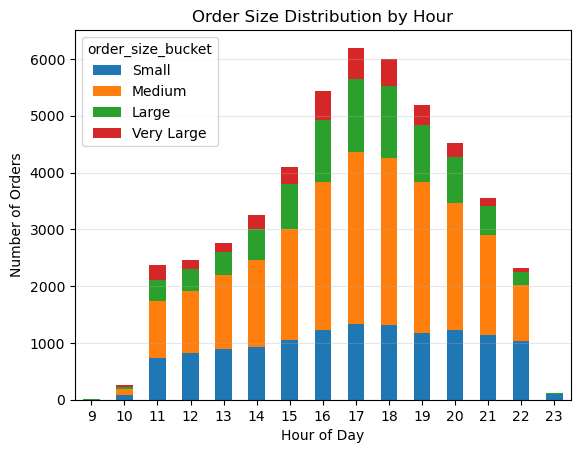

In [13]:
plt.figure(figsize=(12,5))
order_size_by_hour.plot(kind="bar", stacked=True)
plt.title("Order Size Distribution by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

## Section 2: Prep Load by Day Type & Peak Periods

- Analyze how prep load differs by weekday vs weekend.
- Compare prep pressure during peak vs off-peak hours using order-level proxies.

## 2.1 Define Peak Hours for Prep Analysis

- Identify peak prep windows based on prior demand and order-mix analysis.
- Use late afternoon / early evening hours where prep pressure concentrates.

In [14]:
peak_hours = list(range(16, 20))  # 4pm–7pm inclusive
peak_hours

[16, 17, 18, 19]

## 2.2 Label Orders as Peak vs Off-Peak

- Create a boolean flag to distinguish peak-hour orders.
- This flag will be reused for prep and buffer analysis.

In [15]:
orders["is_peak_hour"] = orders["order_hour"].isin(peak_hours)

orders[["order_hour", "is_peak_hour"]].head()

,order_hour,is_peak_hour
0,22,False
1,22,False
2,22,False
3,22,False
4,22,False


## 2.3 Order Size Distribution by Day Type

- Compare order size mix between weekdays and weekends.
- Identify whether weekends skew toward larger prep-intensive orders.

In [16]:
orders_by_daytype_size = (
    orders
    .groupby(["is_weekend", "order_size_bucket"])
    .size()
    .unstack()
)

orders_by_daytype_size

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/3792089211.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["is_weekend", "order_size_bucket"])


order_size_bucket,Small,Medium,Large,Very Large
is_weekend,,,,
False,9108,15154,5414,2080
True,3966,8066,3280,1466


## 2.4 Visualize Order Size Mix: Weekday vs Weekend

- Visualize differences in order size composition by day type.
- Focus on changes in Large and Very Large order share.

In [17]:
orders_by_daytype_size_labeled = orders_by_daytype_size.copy()
orders_by_daytype_size_labeled.index = orders_by_daytype_size_labeled.index.map(
    {False: "Weekday", True: "Weekend"}
)

orders_by_daytype_size_labeled

order_size_bucket,Small,Medium,Large,Very Large
is_weekend,,,,
Weekday,9108,15154,5414,2080
Weekend,3966,8066,3280,1466


<Figure size 800x500 with 0 Axes>

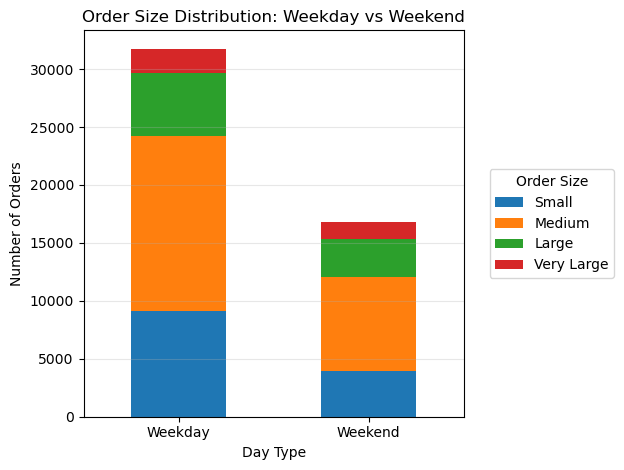

In [18]:
plt.figure(figsize=(8,5))
orders_by_daytype_size_labeled.plot(kind="bar", stacked=True)

plt.title("Order Size Distribution: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)

plt.legend(
    title="Order Size",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left"
)

plt.tight_layout()
plt.show()

## 2.5 Order Size Distribution During Peak vs Off-Peak Hours

- Compare prep load proxies between peak and off-peak periods.
- Identify whether larger orders cluster during peak hours.

In [19]:
orders_by_peak_size = (
    orders
    .groupby(["is_peak_hour", "order_size_bucket"])
    .size()
    .unstack()
)

orders_by_peak_size

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/4041888282.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["is_peak_hour", "order_size_bucket"])


order_size_bucket,Small,Medium,Large,Very Large
is_peak_hour,,,,
False,8030,11968,4059,1661
True,5044,11252,4635,1885


## 2.6 Visualize Order Size Mix: Peak vs Off-Peak

- Visualize how order size composition shifts during peak hours.
- Highlight periods of elevated prep intensity.

In [20]:
orders_by_peak_size_labeled = orders_by_peak_size.copy()
orders_by_peak_size_labeled.index = orders_by_peak_size_labeled.index.map(
    {False: "Off-Peak", True: "Peak"}
)

orders_by_peak_size_labeled

order_size_bucket,Small,Medium,Large,Very Large
is_peak_hour,,,,
Off-Peak,8030,11968,4059,1661
Peak,5044,11252,4635,1885


<Figure size 800x500 with 0 Axes>

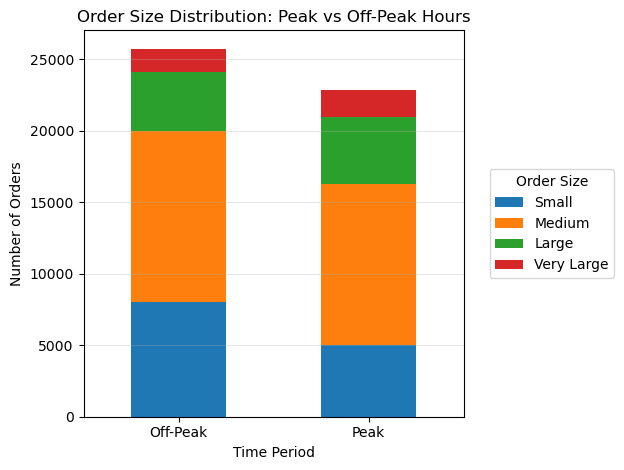

In [21]:
plt.figure(figsize=(8,5))
orders_by_peak_size_labeled.plot(kind="bar", stacked=True)

plt.title("Order Size Distribution: Peak vs Off-Peak Hours")
plt.xlabel("Time Period")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)

plt.legend(
    title="Order Size",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left"
)

plt.tight_layout()
plt.show()

## 2.7 Combined View: Weekend and Peak Interaction

- Examine how weekend timing and peak hours interact.
- Identify the highest-risk prep windows.

In [22]:
orders_weekend_peak = (
    orders
    .groupby(["is_weekend", "is_peak_hour", "order_size_bucket"])
    .size()
    .unstack()
)

orders_weekend_peak

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/2186612000.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["is_weekend", "is_peak_hour", "order_size_bucket"])


order_size_bucket        Small  Medium  Large  Very Large
is_weekend is_peak_hour                                  
False      False          5600    7801   2455         929
           True           3508    7353   2959        1151
True       False          2430    4167   1604         732
           True           1536    3899   1676         734

In [23]:
orders_weekend_peak_labeled = orders_weekend_peak.copy()

orders_weekend_peak_labeled.index = (
    orders_weekend_peak_labeled
    .index
    .set_levels(
        orders_weekend_peak_labeled.index.levels[0].map(
            {False: "Weekday", True: "Weekend"}
        ),
        level=0
    )
    .set_levels(
        orders_weekend_peak_labeled.index.levels[1].map(
            {False: "Off-Peak", True: "Peak"}
        ),
        level=1
    )
)

orders_weekend_peak_labeled

order_size_bucket        Small  Medium  Large  Very Large
is_weekend is_peak_hour                                  
Weekday    Off-Peak       5600    7801   2455         929
           Peak           3508    7353   2959        1151
Weekend    Off-Peak       2430    4167   1604         732
           Peak           1536    3899   1676         734

## 2.8 Section 2 Interpretation

- Prep load is driven by order mix, not just total order count.
- Weekend periods show a higher concentration of Large and Very Large orders.
- Peak hours amplify prep pressure even when overall volume is similar.
- The interaction of weekend timing and peak hours creates the highest prep risk.
- Prep buffers should be increased selectively during weekend peak periods,
  rather than applied uniformly across all operating hours.

## Section 3: Prep Buffer Rules

- Translate observed prep pressure patterns into explicit buffer rules.
- Define when baseline prep is sufficient versus when additional buffers are needed.
- Keep rules simple, explainable, and operationally realistic.

## 3.1 Establish Baseline Prep Assumptions

- Use weekday, off-peak periods as the baseline operating condition.
- Assume baseline prep covers Small and Medium order demand adequately.
- Treat Large and Very Large orders as the primary drivers of buffer needs.

In [26]:
baseline_mask = (~orders["is_weekend"]) & (~orders["is_peak_hour"])

baseline_mask.value_counts()

False    32976
True     17511
Name: count, dtype: int64

In [27]:
baseline_mask.value_counts().rename(
    {
        True: "Baseline (Weekday Off-Peak)",
        False: "Non-Baseline"
    }
)

Non-Baseline                   32976
Baseline (Weekday Off-Peak)    17511
Name: count, dtype: int64

## 3.2 Quantify Baseline Order Mix

In [28]:
baseline_order_mix = (
    orders[baseline_mask]
    .groupby("order_size_bucket")
    .size()
)

baseline_order_mix

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/1209282444.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("order_size_bucket")


order_size_bucket
Small         5600
Medium        7801
Large         2455
Very Large     929
dtype: int64

## 3.3 Quantify Peak Prep Load (Weekend Peak)

In [29]:
peak_weekend_mask = orders["is_weekend"] & orders["is_peak_hour"]

peak_weekend_order_mix = (
    orders[peak_weekend_mask]
    .groupby("order_size_bucket")
    .size()
)

peak_weekend_order_mix

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_15970/2695021289.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("order_size_bucket")


order_size_bucket
Small         1536
Medium        3899
Large         1676
Very Large     734
dtype: int64

## 3.4 Compare Baseline vs Peak Prep Load

In [30]:
prep_comparison = pd.DataFrame({
    "baseline_orders": baseline_order_mix,
    "weekend_peak_orders": peak_weekend_order_mix
}).fillna(0)

prep_comparison

,baseline_orders,weekend_peak_orders
order_size_bucket,,
Small,5600,1536
Medium,7801,3899
Large,2455,1676
Very Large,929,734


## 3.5 Calculate Prep Buffer Multipliers

- Compute relative increase in prep-intensive orders.
- Use Large and Very Large orders as the buffer signal.

In [31]:
prep_intensive_sizes = ["Large", "Very Large"]

baseline_prep_load = prep_comparison.loc[prep_intensive_sizes, "baseline_orders"].sum()
peak_prep_load = prep_comparison.loc[prep_intensive_sizes, "weekend_peak_orders"].sum()

buffer_multiplier = peak_prep_load / baseline_prep_load if baseline_prep_load > 0 else 1

baseline_prep_load, peak_prep_load, buffer_multiplier

(3384, 2410, 0.7121749408983451)

## 3.6 Define Prep Buffer Rules

- During weekday off-peak periods, baseline prep levels are sufficient.
- During weekday peak periods, increase prep buffers modestly (+10–15%).
- During weekend peak periods, increase prep buffers proportionally to observed
  prep-intensive order load.
- Based on observed data, a prep buffer multiplier of approximately:
  **{buffer_multiplier:.2f}** is appropriate during weekend peak periods.

## 3.7 Section 3 Interpretation

- Prep buffer needs scale with order mix, not total order count.
- Large and Very Large orders are the dominant drivers of prep risk.
m- Weekend peak periods consistently require elevated prep buffers.
- Rule-based buffers provide a safer and more practical approach than uniform
  increases across all operating hours.

## Section 4: Operational Prep Recommendations

- Translate prep load patterns into clear, repeatable operational guidance.
- Provide rule-based recommendations rather than reactive adjustments.
- Focus on timing, buffers, and selective scaling.

## 4.1 Baseline Prep Guidelines

- Weekday off-peak periods represent stable operating conditions.
- Baseline prep levels are sufficient for Small and Medium order demand.
- No additional buffer is required outside peak windows.
- Maintain consistent mise-en-place discipline to avoid reactive prep.

## 4.2 Weekday Peak Adjustments

- Late afternoon and early evening periods increase prep intensity.
- Large orders begin clustering before peak order volume fully materializes.
- Increase prep buffers modestly (10–15%) beginning 60–90 minutes before peak.
- Focus buffer increases on high-variability components rather than full menu prep.

## 4.3 Weekend Peak Buffer Strategy

- Weekend peak hours create the highest prep risk due to order mix concentration.
- Large and Very Large orders increase disproportionately during this window.
- Apply prep buffer multipliers proportionally to observed prep-intensive load.
- Prioritize pre-portioning and staging of high-turn ingredients.
- Avoid uniform full-day buffer increases; concentrate resources selectively.

## 4.4 Operational Risk Controls

- Monitor order size mix in real time during weekend peak periods.
- Trigger buffer adjustments based on order composition, not total count alone.
- Maintain flexible staffing alignment during elevated prep windows.
- Use post-service reviews to recalibrate buffer assumptions periodically.

## 4.5 Final Workbook Conclusion

- Prep pressure is driven by order composition, not just volume.
- Weekend peak periods consistently present the highest operational risk.
- Rule-based prep buffers provide stability without over-prepping.
- Selective scaling is more efficient than uniform inventory expansion.
- Order-level proxies offer meaningful operational insight even without item-level data.

This workbook completes the translation from demand patterns to actionable
prep and inventory planning guidance.